## Assignment 7

In [38]:
%matplotlib inline

import numpy as np

import pystan
import stan_utility
import psis

import matplotlib
import matplotlib.pyplot as plt

font = {'size': 16}

matplotlib.rc('font', **font)

print('numpy', np.__version__)
print('pystan', pystan.__version__)

numpy 1.14.1
pystan 2.17.1.0


### 1. Model assessment: LOO-CV for factory data with Stan

Some utility functions

In [70]:
def p_eff(loo, log_likelihood):
    loo_ll = np.sum(np.log(np.mean(np.exp(log_likelihood), axis = 0)))
    return loo_ll - loo

In [90]:
def loohist(model, loos):
    fig, ax = plt.subplots(figsize = (16, 6))
    ax.set_title(model + r' model, PSIS-LOO-log posterior distribution')
    ax.hist(loos, fc=(23/255, 190/255, 207/255, 0.25), linestyle = '-', linewidth = 1, edgecolor = 'C9')
    ax.set_xlabel(r'$\mathrm{log}(\mathrm{PSIS-LOO})$')
    ax.set_ylabel(r'count')

In [56]:
def khist(model, ks):
    fig, ax = plt.subplots(figsize = (16, 6))
    ax.set_title(model + r' model, $k$-values distribution')
    ax.hist(ks, bins=np.arange(.9, step = .1), fc=(23/255, 190/255, 207/255, 0.25), linestyle = '-', linewidth = 1, edgecolor = 'C9')
    ax.set_xlabel(r'$k$')
    ax.set_ylabel(r'count')
    ax.vlines(x = .7, color = 'red', ymin = 0, ymax = 12)

We load the data

In [10]:
data_factory = np.loadtxt('../data/factory.txt')
data_factory.shape

(5, 6)

We fit the models as described in the previous assignment

#### 1.1 Separate model
For the seperate model we fit each machine using independent $\mu_j$ and $\sigma_j$:

In [16]:
stan_code = """
data {
  int<lower=0> N;            // number of data points
  int<lower=0> K;            // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y;               // target
}
parameters {
  vector[K] mu;              // group means
  vector<lower=0>[K] sigma;  // group std
}
model {
  y ~ normal(mu[x], sigma[x]);
}
generated quantities {
    vector[N] log_likelihood;
    for(n in 1:N)
        log_likelihood[n] = normal_log(y[n], mu[x[n]], sigma[x[n]]);
}
"""

model_separate = pystan.StanModel(model_code = stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f47d3427291e8c13645a4740e9b0976d NOW.


In [17]:
x = np.tile(np.arange(1, data_factory.shape[1] + 1), data_factory.shape[0])
y = data_factory.flatten()
N = len(x)
K = np.max(x)

fit_separate = model_separate.sampling(
    data = {
        'N': N,
        'K': K,
        'x': x,
        'y': y
    })

c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We check the fitted parameters and the performance of the fit, i.e. the treedepth, E-BFMI, and divergences:

In [18]:
stan_utility.check_treedepth(fit_separate)
stan_utility.check_energy(fit_separate)
stan_utility.check_div(fit_separate)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


In [22]:
params_separate = fit_separate.extract()

We run PSIS-LOO on the generated log likelihood

In [63]:
loo_separate, loos_separate, ks_separate = psis.psisloo(params_separate['log_likelihood'])

 We plot the distribution of the $\text{PSIS-LOO}$-values

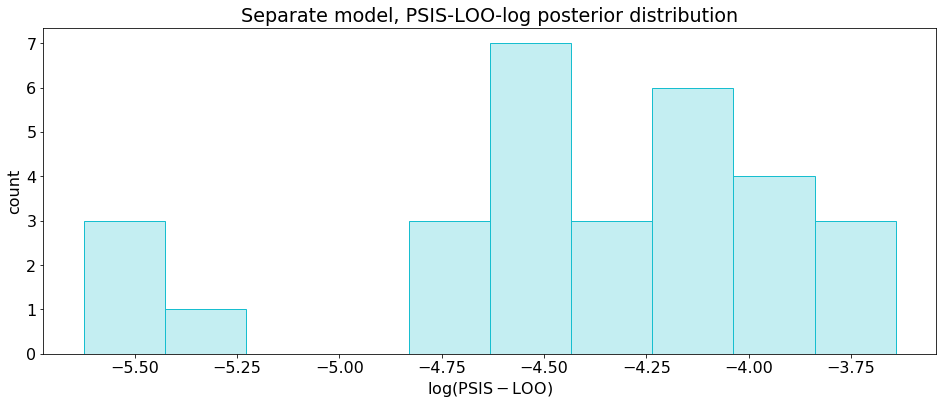

In [91]:
loohist('Separate', loos_separate)

We report the effective number of parameters $p_\mathrm{eff}$:

In [72]:
p_eff(loo_separate, params_separate['log_likelihood'])

9.615312590848063

We inspect the $k$-values vizually, and see that 2 of the $k$-values exceed the threshold $0.7$, e.g. $6.7\%$. So there is a concern that the accuracy may be biased (too optimistic, overestimating the predictive accuracy of the model).

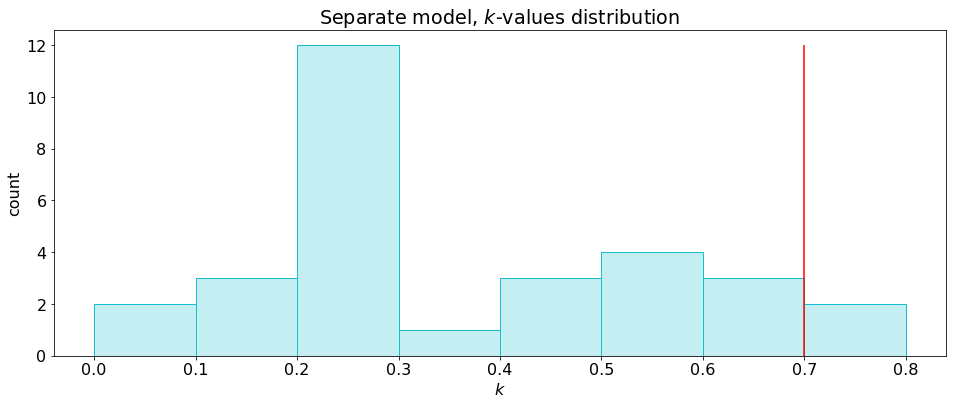

In [64]:
khist('Separate', ks_separate)

#### 2.1 Pooled model
For the pooled model we fit all as a single machine, e.g. $x_j = 1$ for all $j = 1 \ldots 6$, and $K = 1$.

In [52]:
x_pooled = np.array([1] * len(y))

fit_pooled = model_separate.sampling(
    data = {
        'N': N,
        'K': 1,
        'x': x_pooled,
        'y': y
    })

c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We check the fitted parameters and the performance of the fit, i.e. the treedepth, E-BFMI, and divergences:

In [53]:
stan_utility.check_treedepth(fit_pooled)
stan_utility.check_energy(fit_pooled)
stan_utility.check_div(fit_pooled)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


In [54]:
params_pooled = fit_pooled.extract()

We run PSIS-LOO on the generated log likelihood

In [57]:
loo_pooled, loos_pooled, ks_pooled = psis.psisloo(params_pooled['log_likelihood'])

 We plot the distribution of the $\text{PSIS-LOO}$-values

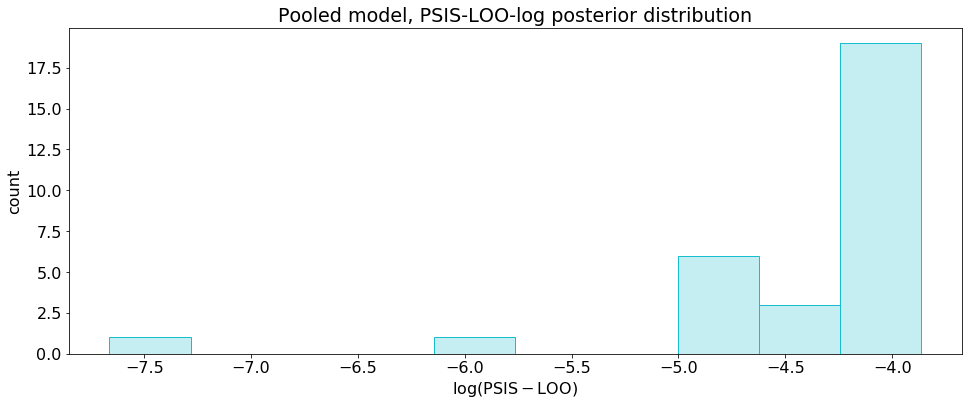

In [92]:
loohist('Pooled', loos_pooled)

We report the effective number of parameters $p_\mathrm{eff}$:

In [93]:
p_eff(loo_pooled, params_pooled['log_likelihood'])

2.0508441730696063

We inspect the $k$-values vizually, and see that none of the $k$-values exceed the threshold $0.7$. So accuracy is assesed to be reliable.

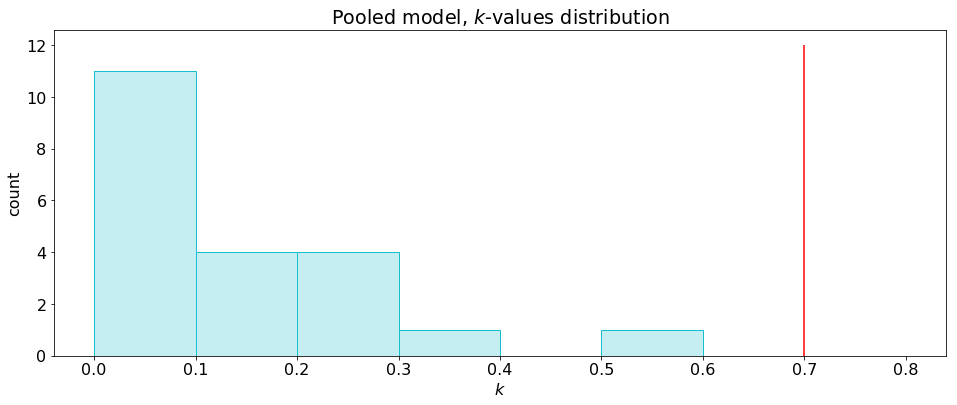

In [94]:
khist('Pooled', ks_pooled)

#### 1.3 Hierarchical model

In [61]:
stan_code_hierarchical = """
data {
  int<lower=0> N;            // number of data points
  int<lower=0> K;            // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y;               // target
}
parameters {
  real mu_prior;             // shared prior mean
  real<lower=0> sigma_prior; // shared prior std
  vector[K] mu;              // group means
  real<lower=0> sigma;       // shared std
}
model {
  for (k in 1:K) {
    mu[k] ~ normal(mu_prior, sigma_prior);
  }
  y ~ normal(mu[x], sigma);
}
generated quantities {
    vector[N] log_likelihood;
    for(n in 1:N)
        log_likelihood[n] = normal_log(y[n], mu[x[n]], sigma);
}
"""

model_hierarchical = pystan.StanModel(model_code = stan_code_hierarchical)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a24b668e4cbeee7bed03087a42d25f05 NOW.


In [65]:
fit_hierarchical = model_hierarchical.sampling(
    data = {
        'N': N,
        'K': K,
        'x': x,
        'y': y
    })

c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We check the fitted parameters and the performance of the fit, i.e. the treedepth, E-BFMI, and divergences:

In [66]:
stan_utility.check_treedepth(fit_hierarchical)
stan_utility.check_energy(fit_hierarchical)
stan_utility.check_div(fit_hierarchical)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
21.0 of 4000 iterations ended with a divergence (0.525%)
Try running with larger adapt_delta to remove the divergences


We see some iterations ended with a divergence, but since it is such small fraction, we accept the performance.

In [67]:
params_hierarchical = fit_hierarchical.extract()

We run PSIS-LOO on the generated log likelihood

In [68]:
loo_hierarchical, loos_hierarchical, ks_hierarchical = psis.psisloo(params_hierarchical['log_likelihood'])

 We plot the distribution of the $\text{PSIS-LOO}$-values

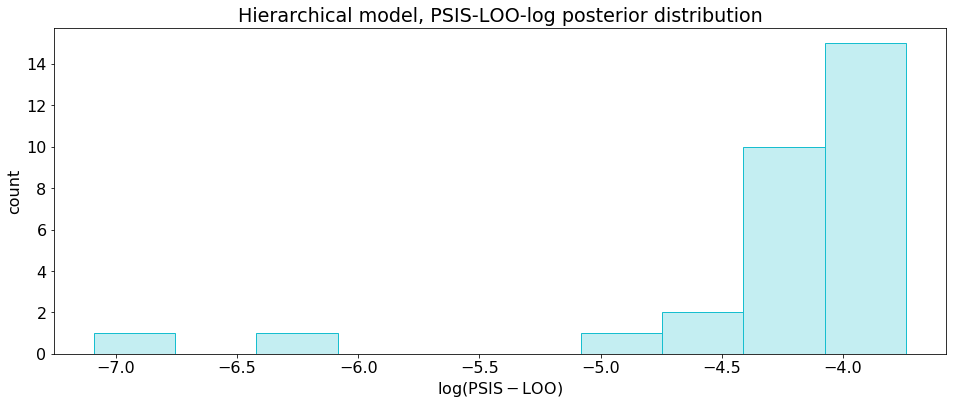

In [96]:
loohist('Hierarchical', loos_hierarchical)

We report the effective number of parameters $p_\mathrm{eff}$:

In [97]:
p_eff(loo_hierarchical, params_hierarchical['log_likelihood'])

5.529017224113474

We inspect the $k$-values vizually, and see that none of the $k$-values exceed the threshold $0.7$. So accuracy is assesed to be reliable.

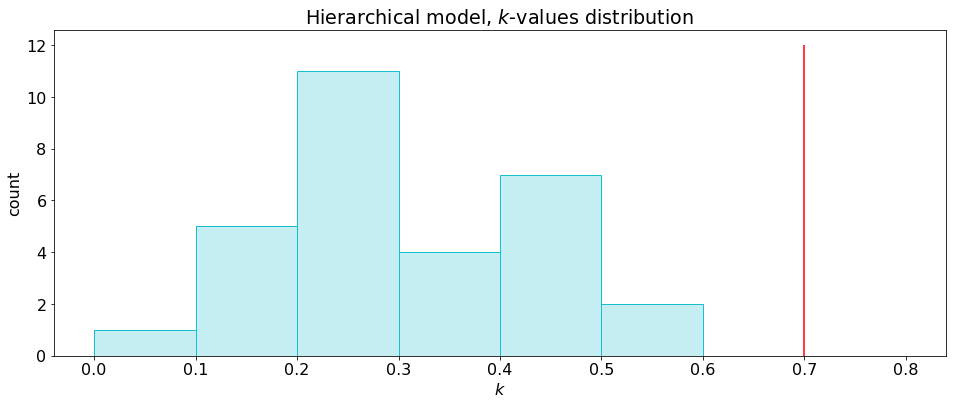

In [69]:
khist('Hierarchical', ks_hierarchical)

#### 1.4 Conclusions

In the seperate model, we see the results for the approximate LOO-CV are unreliable, and thus we cannot use the approximated PSIS-LOO values for determining if this model should not be selected. The approximate LOO-CV results for the pooled and hierarchical models are on the other hand reliable.

The $k$-values distribution for the pooled model is not symetric, and based in the performance of $p_\mathrm{eff}(\mathrm{Pooled})$ and $p_\mathrm{eff}(\mathrm{Hierarchical})$ we etablish, that the hierarchical model is preferred over the pooled.
